# Identify Peaks using Object Tracking
We are going to find which peaks are the same between frames by treating them as particles then using object tracking to associate them between frames.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy.polynomial import Polynomial
import trackpy as tp
import pandas as pd
import numpy as np

## Load in Peak Locations
Get the peak locations from the previous notebook

In [2]:
frame_data = pd.read_pickle('peak_data.pkl.gz')
print(f'Loaded data from {len(frame_data)} frames')

Loaded data from 256 frames


## Reshape into a per-particle dataframe
Trackpy wants the x and y coordinates for each particle.

In [3]:
peak_data = []
for fid, frame in frame_data.iterrows():
    offset, height = frame['peak_locs'].T
    peak_data.append(pd.DataFrame({
        'time_hr': frame['time_hr'],
        'offset': offset,
        'height': height,
        'log_height': np.log(height),
        'frame': [fid] * len(offset)
    }))
peak_data = pd.concat(peak_data)
print(f'Found a total of {len(peak_data)} peaks')

Found a total of 4117 peaks


In [4]:
peak_data.head()

,time_hr,offset,height,log_height,frame
0,0.251189,8.138739,1.135388,0.126974,0
1,0.251189,8.123152,1.176360,0.162425,0
2,0.251189,8.081189,2.753516,1.012879,0
3,0.251189,8.065602,2.796348,1.028314,0
4,0.251189,7.970165,0.597685,-0.514691,0


Make the x- and y- coordinates the scaled values

In [5]:
for a, b in zip(['x', 'y'], ['offset', 'log_height']):
    peak_data[a] = (peak_data[b] - peak_data[b].min()) / (peak_data[b].max() - peak_data[b].min())

Text(0, 0.5, '$y$ (Height)')

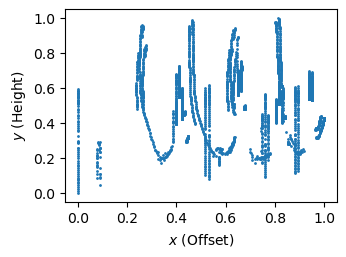

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(peak_data['x'], peak_data['y'], s=1)

ax.set_xlabel('$x$ (Offset)')
ax.set_ylabel('$y$ (Height)')

You can see the tracks in these images, it's just a matter of associating them

## Perform the tracking
We are going to use 

In [7]:
peak_data['y'] = 1  # Do not use the height
pred = tp.predict.NearestVelocityPredict(span=8)
peak_data = pred.link_df(peak_data, search_range=0.01, memory=16)
print(f'Found {peak_data.particle.max() + 1} unique peaks')

Frame 255: 24 trajectories present.
Found 46 unique peaks


In [8]:
peak_data.head()

,time_hr,offset,height,log_height,frame,x,y,particle
0,0.251189,8.138739,1.135388,0.126974,0,1.000000,1,0
1,0.251189,8.123152,1.176360,0.162425,0,0.986658,1,1
2,0.251189,8.081189,2.753516,1.012879,0,0.950739,1,2
3,0.251189,8.065602,2.796348,1.028314,0,0.937397,1,3
4,0.251189,7.970165,0.597685,-0.514691,0,0.855706,1,4


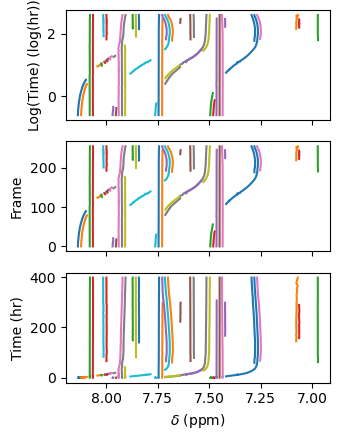

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 4.5), sharex=True)

for _, group in peak_data.groupby('particle'):
    axs[0].plot(group['offset'], np.log10(group['time_hr']), '-', lw=1.5)
    axs[1].plot(group['offset'], group['frame'], '-', lw=1.5)
    axs[2].plot(group['offset'], group['time_hr'], '-', lw=1.5)

for ax, l in zip(axs, ['Log(Time) (log(hr))', 'Frame', 'Time (hr)']):
    ax.set_ylabel(l)
    
axs[0].set_xlim(axs[0].get_xlim()[::-1])
axs[-1].set_xlabel('$\delta$ (ppm)')

fig.tight_layout()
fig.savefig('grouped.png', dpi=320)

It does succeed in getting peaks which move over time, but we don't get the the crossover. We're going to have to do more work on tracking

## Group Segments Together
Let's find which elements have similar rates of change of $\delta$ at a certain position

In [19]:
target_frame = 215

In [20]:
track_data = []
frame_time = frame_data.loc[target_frame]['time_hr']
for tid, track in peak_data.groupby('particle'):
    # Find if we have frames near the target
    frame = {'track': tid, 'valid': False}
    if np.abs(track['frame'] - target_frame).min() > 1: 
        track_data.append(frame)
        continue
        
    # Fit a spline for \delta(log(t))
    window = 0.2
    track = track.query(f'{frame_time * window} < time_hr < {frame_time / window}')
    f = Polynomial.fit(np.log(track['time_hr']), track['offset'], 5)
    
    # Get the velocity and acceleration
    frame['valid'] = True
    frame['delta_vel'] = f.deriv(1)(np.log(frame_time))
    frame['delta_acc'] = f.deriv(2)(np.log(frame_time))
    track_data.append(frame)
track_data = pd.DataFrame(track_data)

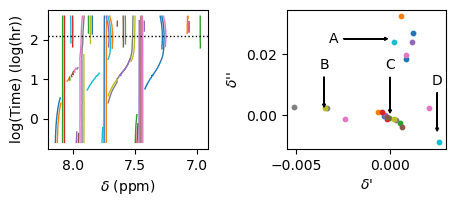

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.))

for i, track in track_data.iterrows():
    axs[1].scatter([track['delta_vel']], [track['delta_acc']], s=10)
    
    group = peak_data.query(f'particle=={i}')
    axs[0].plot(group['offset'], np.log10(group['time_hr']), '-', lw=1.)
    
axs[1].set_xlabel('$\delta$\'')
axs[1].set_ylabel('$\delta$\'\'')

axs[0].set_xlim(axs[0].get_xlim()[::-1])
axs[0].set_xlabel('$\delta$ (ppm)')
axs[0].set_ylabel('log(Time) (log(hr))')

# Put the chosen time
axs[0].plot(ax.get_xlim(), np.log10([frame_time] * 2), 'k:', lw=1)

# Annotate the clusters
arrowprops=dict(facecolor='black', shrink=0.05, width=0.1, headwidth=2, headlength=2)
axs[1].annotate('D', xy=(0.0025, -0.006), xytext=(0.0025, 0.01), arrowprops=arrowprops, ha='center')
axs[1].annotate('C', xy=(0, 0.), xytext=(-0., 0.015), arrowprops=arrowprops, ha='center')
axs[1].annotate('B', xy=(-0.0035, 0.002), xytext=(-0.0035, 0.015), arrowprops=arrowprops, ha='center')
axs[1].annotate('A', xy=(0.0, 0.025), xytext=(-0.003, 0.025), arrowprops=arrowprops, ha='center', va='center')

fig.tight_layout(pad=0.5)
fig.savefig('figures/compare-derivatives.png', dpi=320)

We can see some clusters forming based on the slope and curvature of $\delta$ over time.